<a href="https://colab.research.google.com/github/Karthigai05/Co2_emission-calculator/blob/main/CO2_Calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from ast import literal_eval
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MultiLabelBinarizer

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


In [ ]:
df = pd.read_csv('/content/carbon emission mitigation 1.xls')

# change display settings to show all columns
pd.set_option('display.max_columns', None)

#rename
# rename columns: replace spaces with underscores
df.columns = df.columns.str.replace(' ', '_')

# convert Gender to Boolean-datatyp
df.rename(columns= {'Sex':'Gender'}, inplace = True)

df.head()

,Body_Type,Gender,Diet,How_Often_Shower,Heating_Energy_Source,Transport,Vehicle_Type,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Recycling,Cooking_With,CarbonEmission
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,210,large,4,7,26,1,No,['Metal'],"['Stove', 'Oven']",2238
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,['Metal'],"['Stove', 'Microwave']",1892
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,2472,small,1,14,47,6,Sometimes,['Metal'],"['Oven', 'Microwave']",2595
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,"['Paper', 'Plastic', 'Glass', 'Metal']","['Microwave', 'Grill', 'Airfryer']",1074
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,8457,large,1,3,5,6,Yes,['Paper'],['Oven'],4743


In [ ]:
print("Full dataset shape is", df.shape)
##############################################

# Berechnet den maximalen Wert einer Spalte, wenn sie numerisch ist
def max_value(column):
    if pd.api.types.is_numeric_dtype(column):  # Überprüfe, ob der Datentyp numerisch ist
        return column.dropna().max() if not column.dropna().empty else np.nan
    return ""

# Gibt die einzigartigen Werte einer Spalte zurück, oder eine Range (falls es eine gibt)
def get_unique_values(column):
    if pd.api.types.is_integer_dtype(column):  # Überprüfe, ob der Datentyp eine Ganzzahl ist
        unique_vals = sorted(set(column.dropna()))
        min_val, max_val = column.min(), column.max()
        if unique_vals == list(range(min_val, max_val + 1)):
            return f"range({min_val},{max_val + 1})"
        return unique_vals
#        return f"between {min_val} and {max_val}"
    return sorted(set(column.dropna()))


def summary(df=df):
    summary_df = pd.DataFrame({
        'data type': df.dtypes.astype(str),
        'missing data': df.isna().sum(),
        'unique values': [get_unique_values(df[col]) for col in df.columns],
        'unique values max': [max_value(df[col]) for col in df.columns],
        'Cardinality': df.nunique()
    })
    return summary_df


# Sortiere nach 'data type' und dann nach 'number of unique values'
summary_df = summary(df).sort_values(by=['data type', 'Cardinality'])


Full dataset shape is (151, 20)


In [ ]:
max_length_col = len(str("'Stove', 'Oven', 'Microwave', 'Grill', 'Airfryer'"))+2
pd.set_option('max_colwidth', max_length_col + 1) #Set the Column Width #You can increase the width by passing an int. Or put at the max passing None:
#pd.set_option('max_colwidth', None) #Set the Column Width #You can increase the width by passing an int. Or put at the max passing None:
#pd.reset_option('max_colwidth') #Rückgängig machen

summary_df.loc['Vehicle_Type', 'unique values'] = ', '.join(['diesel', 'electric', 'hybrid', 'lpg', 'petrol']) #ist string statt Liste
#summary_df.loc['Vehicle_Type', 'unique values'] = ['diesel', 'electric', 'hybrid', 'lpg', 'petrol'] #macht Fehlermeldung

#change values for "Recycling" & "Cooking_With"

for headline in ["Recycling" ,"Cooking_With"]:
    unique_values= set([item for sublist in df[headline].unique() for item in eval(sublist)]) #eval - Convert string representation of list to an actual list

    summary_df.loc[headline,'unique values'] = str(unique_values)
    summary_df.loc[headline,'Cardinality'] = len(unique_values)


# Setze die maximale Breite einer Spalte auf None, um keine Begrenzung zu haben
#pd.set_option('display.max_colwidth', None)

summary_df

,data type,missing data,unique values,unique values max,Cardinality
Waste_Bag_Weekly_Count,int64,0,"range(1,8)",7,7
How_Long_TV_PC_Daily_Hour,int64,0,"range(0,25)",24,25
How_Long_Internet_Daily_Hour,int64,0,"range(0,25)",24,25
How_Many_New_Clothes_Monthly,int64,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...",50,48
Monthly_Grocery_Bill,int64,0,"[50, 56, 59, 61, 62, 63, 64, 66, 67, 69, 70, 71,...",295,113
Vehicle_Monthly_Distance_Km,int64,0,"[1, 3, 5, 6, 7, 9, 10, 11, 13, 14, 15, 19, 20, 2...",9555,138
CarbonEmission,int64,0,"[657, 671, 706, 807, 810, 877, 950, 953, 1002, 1...",5272,148
Gender,object,0,"[female, male]",,2
Transport,object,0,"[private, public, walk/bicycle]",,3
Social_Activity,object,0,"[never, often, sometimes]",,3


In [ ]:
df.describe()

,Monthly_Grocery_Bill,Vehicle_Monthly_Distance_Km,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,CarbonEmission
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,172.741722,2072.543046,3.529801,12.178808,23.649007,12.370861,2140.066225
std,72.129833,2850.841590,1.962339,7.369384,15.059526,7.129858,913.367956
min,50.000000,1.000000,1.000000,0.000000,0.000000,0.000000,657.000000
25%,110.500000,70.000000,2.000000,6.500000,10.000000,5.500000,1491.000000
50%,174.000000,692.000000,3.000000,13.000000,23.000000,12.000000,1929.000000
75%,235.000000,2672.000000,5.000000,19.000000,37.000000,18.000000,2573.500000
max,295.000000,9555.000000,7.000000,24.000000,50.000000,24.000000,5272.000000


corelations analysis

In [ ]:
df_corr=df[['CarbonEmission','Vehicle_Monthly_Distance_Km','Transport','Vehicle_Type']].copy()

# Rename 'public' to 'public transport' and the car-typs - to make the information easier to understand
df_corr['Vehicle_Type'] = df_corr['Vehicle_Type'].replace({'petrol': 'car (type: petrol)','diesel': 'car (type: diesel)','hybrid': 'car (type: hybrid)','lpg': 'car (type: lpg)','electric': 'car (type: electric)'})
df_corr['Transport'] = df_corr['Transport'].replace({'public': 'public transport', 'private': 'car'})


##create dummy-variables for correlation metric:
for item in df_corr['Transport'].unique():
    df_corr[str(item)] = df_corr['Transport'].apply(lambda x: 1 if item == x else 0)

unique_vehicle_types = df_corr['Vehicle_Type'].dropna().unique().tolist()
for item in unique_vehicle_types:
    df_corr[str(item)] = df_corr['Vehicle_Type'].apply(lambda x: 1 if item == x else 0)

df_corr.head()

,CarbonEmission,Vehicle_Monthly_Distance_Km,Transport,Vehicle_Type,public transport,walk/bicycle,car,car (type: petrol),car (type: diesel),car (type: hybrid),car (type: lpg),car (type: electric)
0,2238,210,public transport,NaN,1,0,0,0,0,0,0,0
1,1892,9,walk/bicycle,NaN,0,1,0,0,0,0,0,0
2,2595,2472,car,car (type: petrol),0,0,1,1,0,0,0,0
3,1074,74,walk/bicycle,NaN,0,1,0,0,0,0,0,0
4,4743,8457,car,car (type: diesel),0,0,1,0,1,0,0,0


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '0-1,000km'),
  Text(1, 0, '1,000-2,000km'),
  Text(2, 0, '2,000-3,000km'),
  Text(3, 0, '3,000-4,000km'),
  Text(4, 0, '4,000-5,000km'),
  Text(5, 0, '5,000-6,000km'),
  Text(6, 0, '6,000-7,000km'),
  Text(7, 0, '7,000-8,000km'),
  Text(8, 0, '8,000-9,000km'),
  Text(9, 0, '9,000-10,000km')])

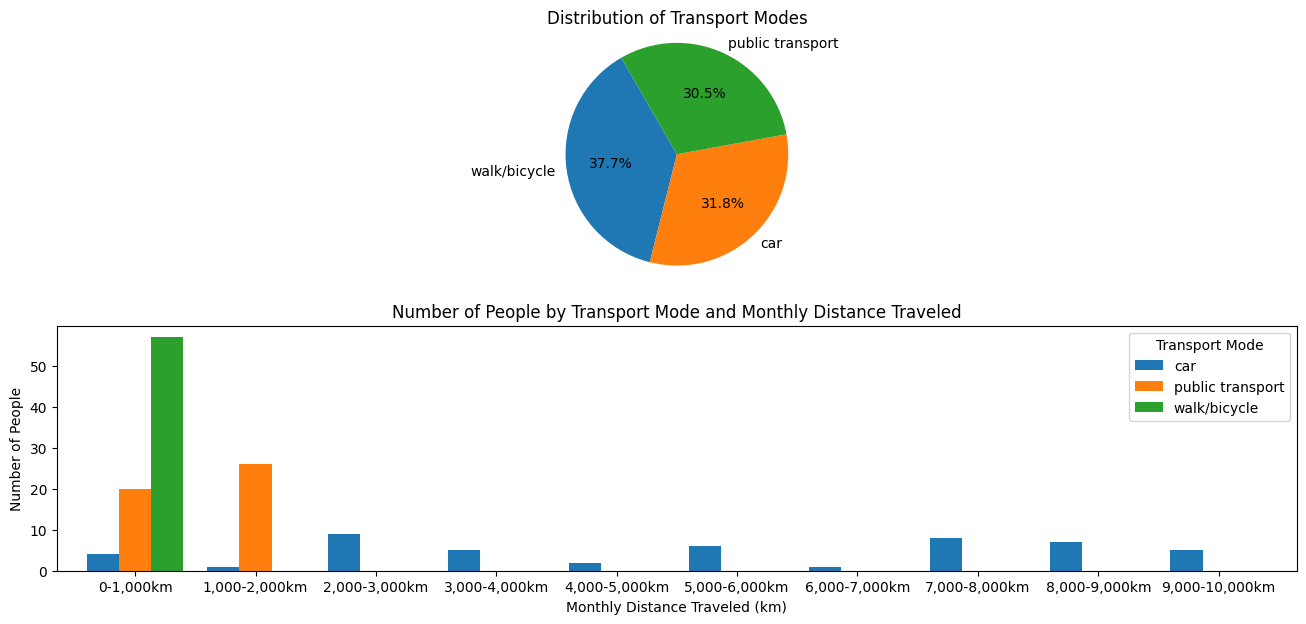

In [ ]:
transport_counts = df_corr['Transport'].value_counts()
labels = [label for label in transport_counts.index]
sizes = transport_counts.values

# Create categories for Vehicle_Monthly_Distance_Km with 10 bins
bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
distance_labels = ["0-1,000km", "1,000-2,000km", "2,000-3,000km", "3,000-4,000km", "4,000-5,000km",
                   "5,000-6,000km", "6,000-7,000km", "7,000-8,000km", "8,000-9,000km", "9,000-10,000km"]
df_corr['Distance_Category'] = pd.cut(df_corr['Vehicle_Monthly_Distance_Km'], bins=bins, labels=distance_labels)

# Calculate the distribution of transport modes within each Distance_Category
counts = df_corr.groupby(['Distance_Category', 'Transport'], observed=True).size().unstack(fill_value=0)

# Create the combined plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 7))


# Pie chart
axes[0].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=120)
axes[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axes[0].set_title("Distribution of Transport Modes")

# Bar plot
counts.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('Number of People by Transport Mode and Monthly Distance Traveled')
axes[1].set_xlabel('Monthly Distance Traveled (km)')
axes[1].set_ylabel('Number of People')
axes[1].legend(title='Transport Mode')
plt.xticks(rotation=0)

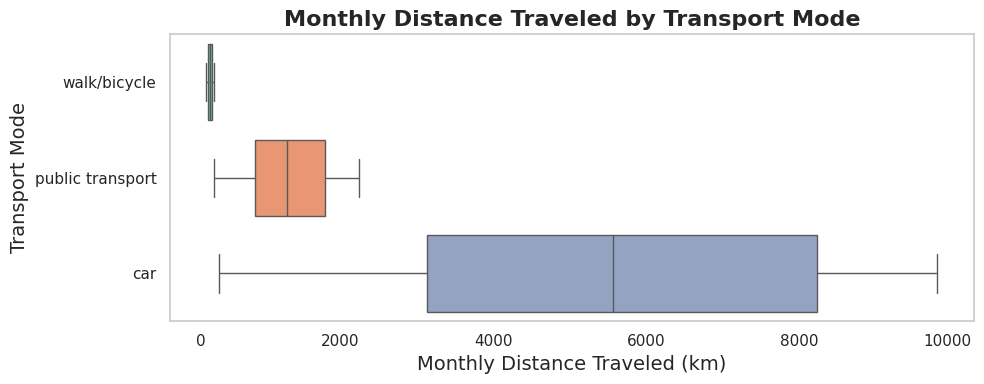

In [ ]:
plt.figure(figsize=(10, 4))
sns.set(style="whitegrid")  # Set background style to "whitegrid"

ax = sns.boxplot(y='Transport', x='Vehicle_Monthly_Distance_Km', data=df_corr, palette="Set2", order=['walk/bicycle','public transport','car'])

# title and axis labels
plt.title('Monthly Distance Traveled by Transport Mode', fontsize=16, weight='bold')
plt.xlabel('Monthly Distance Traveled (km)', fontsize=14)
plt.ylabel('Transport Mode', fontsize=14)


# Remove grid lines
ax.grid(False)

# Rotate X-axis labels for better readability
plt.xticks(rotation=0, ha='right')

# Adjust layout to prevent overlap
plt.tight_layout()

# save the figure in png-format
plt.savefig('boxplot_transport.png')

plt.show()

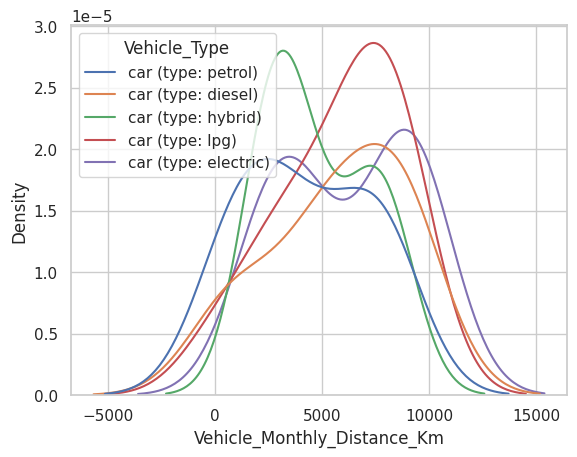

In [ ]:
sns.kdeplot(data=df_corr, x="Vehicle_Monthly_Distance_Km", hue="Vehicle_Type")#,common_norm=False)
plt.show()

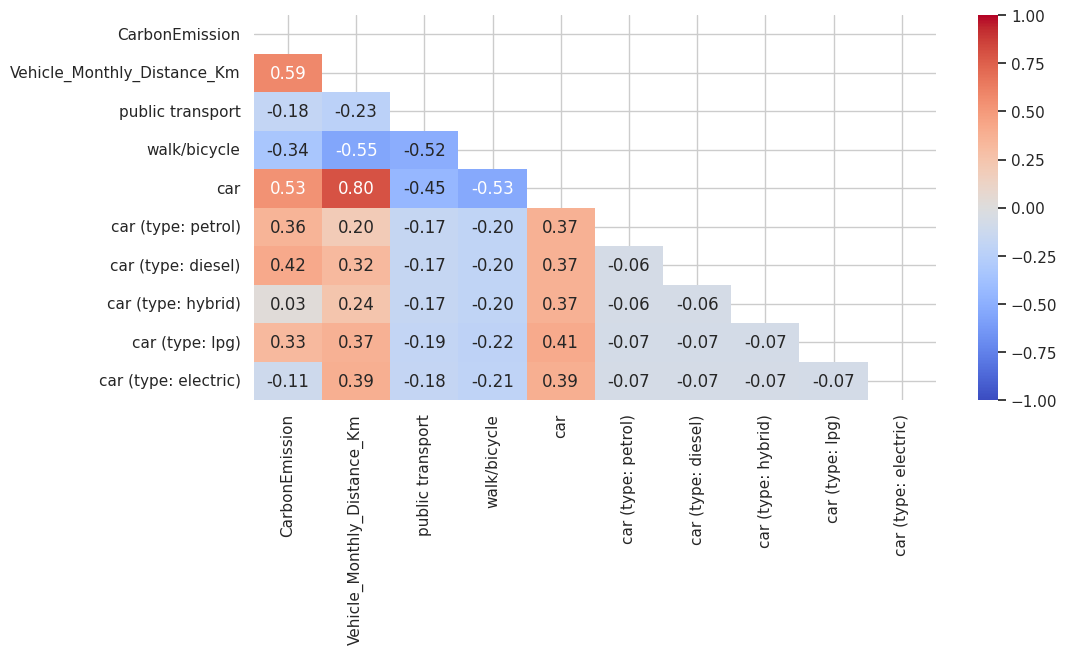

In [ ]:
correlations = df_corr[['CarbonEmission', 'Vehicle_Monthly_Distance_Km', 'public transport', 'walk/bicycle', 'car','car (type: petrol)', 'car (type: diesel)', 'car (type: hybrid)','car (type: lpg)', 'car (type: electric)']].corr()

# delete upper diagonal matrix
mask = np.triu(np.ones_like(correlations, dtype=bool))

plt.figure(figsize=(11, 5))  #size of figure
sns.heatmap(correlations,fmt = '.2f', cmap="coolwarm", annot=True, mask=mask,vmax=1,vmin=-1)
plt.show()

In [ ]:
ordinal_variable_order = {
    'Body_Type': ['underweight', 'normal', 'overweight', 'obese'],
    'Diet': ['vegan','vegetarian','pescatarian','omnivore'],
    'How_Often_Shower': ['less frequently','daily', 'twice a day','more frequently'],
    'Social_Activity': ['never', 'sometimes','often'],
    'Frequency_of_Traveling_by_Air': ['never', 'rarely', 'frequently', 'very frequently'],
    'Waste_Bag_Size': ['small','medium', 'large', 'extra large'],
    'Energy_efficiency': ['Yes', 'Sometimes', 'No']
}

# set the ordering
for column, value_ordering in ordinal_variable_order.items():
    df[column] = pd.Categorical(df[column], categories=value_ordering, ordered=True)

#example
df['Waste_Bag_Size'].unique()

['large', 'extra large', 'small', 'medium']
Categories (4, object): ['small' < 'medium' < 'large' < 'extra large']

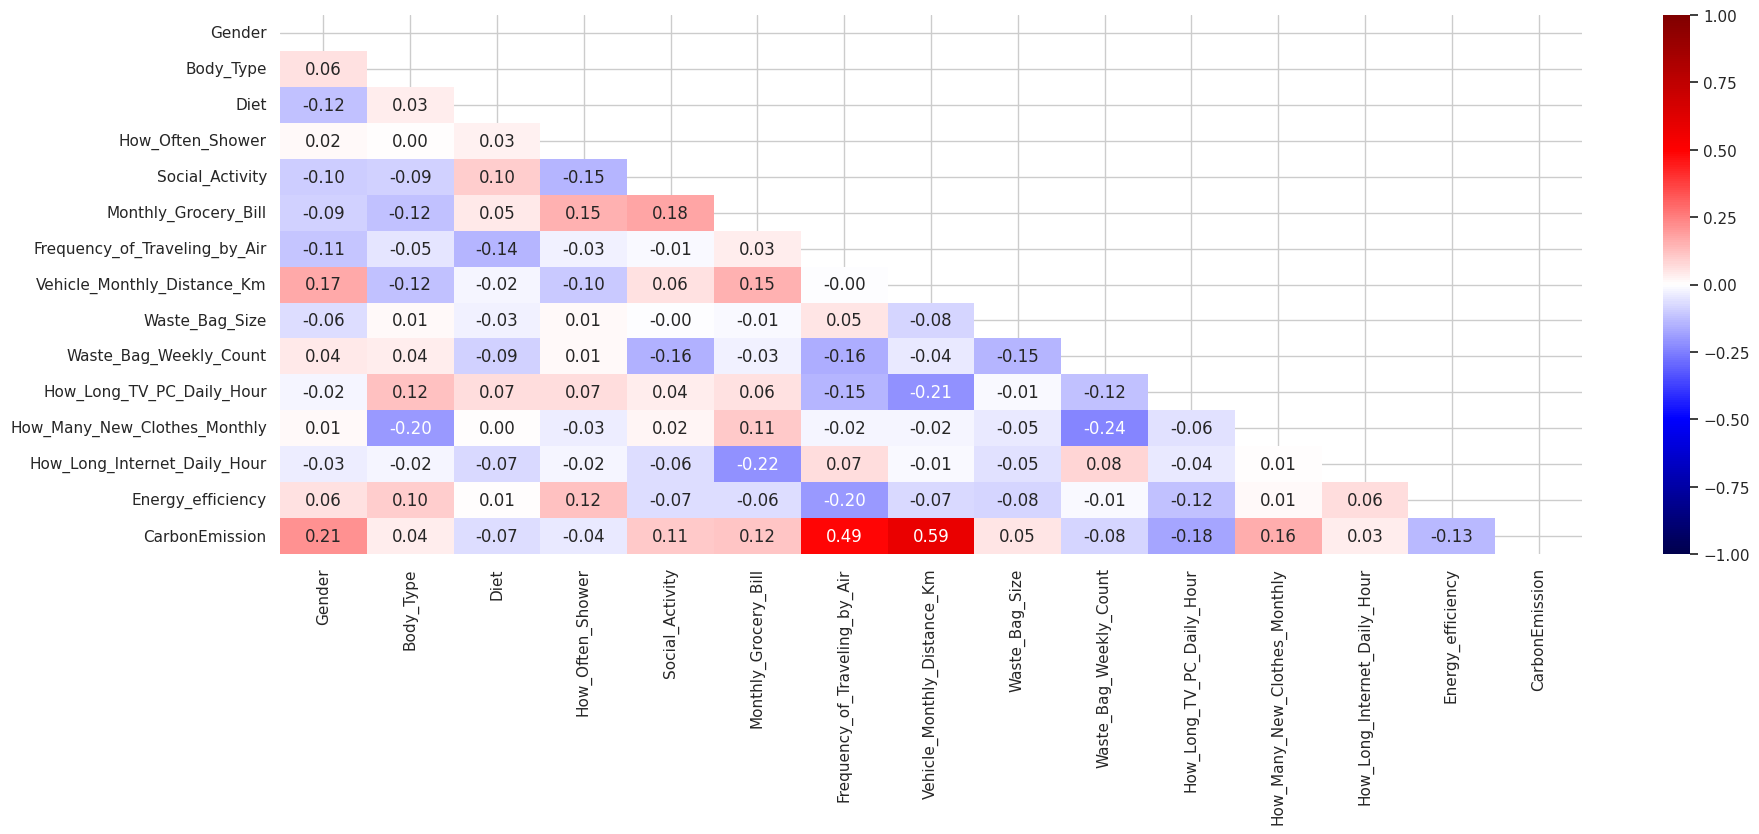

In [ ]:
corr_columns =  ['Gender'] + df.select_dtypes(include=[np.number, 'category']).columns.tolist()
df_corr_ordinal = df[corr_columns].copy()

# convert Gender to Boolean-datatyp
df_corr_ordinal['Gender'] = df['Gender'].map({'male': True, 'female': False})


# encoding for ordinal variables based on defined order
for column, column_ordering in ordinal_variable_order.items():
   mapping = {category: idx for idx, category in enumerate(column_ordering)}
   df_corr_ordinal[column] = df[column].map(mapping)

# delete upper diagonal matrix
mask = np.triu(np.ones_like(df_corr_ordinal.corr(), dtype=bool))

plt.figure(figsize=(21, 7))  #size of figure
#sns.heatmap(df_corr_ordinal.corr(),fmt = '.2f', cmap="coolwarm", annot=True)
sns.heatmap(df_corr_ordinal.corr(),fmt = '.2f', cmap="seismic", annot=True, mask=mask,vmax=1,vmin=-1) # cmap="coolwarm"  cmap="seismic"
plt.show()

In [ ]:
pd.DataFrame(df_corr_ordinal.corr()["CarbonEmission"].round(3).abs().sort_values(ascending=False)[1:])

,CarbonEmission
Vehicle_Monthly_Distance_Km,0.586
Frequency_of_Traveling_by_Air,0.489
Gender,0.215
How_Long_TV_PC_Daily_Hour,0.178
How_Many_New_Clothes_Monthly,0.164
Energy_efficiency,0.135
Monthly_Grocery_Bill,0.117
Social_Activity,0.108
Waste_Bag_Weekly_Count,0.084
Diet,0.069


data preprocessing

In [ ]:
print("Number of Duplicates:", df.duplicated().sum())

Number of Duplicates: 0


In [ ]:
df2 = df[['Cooking_With']].copy()
df2['Cooking_With_Grill'] = df2['Cooking_With'].apply(lambda x: 1 if "Grill" in x else 0)
df2['Cooking_With_Airfryer'] = df2['Cooking_With'].apply(lambda x: 1 if "Airfryer" in x else 0)

print("4992 people have both an air fryer and a grill, 5008 people have neither. No one has only one of the two devices.")
pd.DataFrame(df2.groupby(["Cooking_With_Airfryer","Cooking_With_Grill"]).size())

4992 people have both an air fryer and a grill, 5008 people have neither. No one has only one of the two devices.


,,0
Cooking_With_Airfryer,Cooking_With_Grill,
0,0,78
1,1,73


In [ ]:
print("unique values:", set([item for sublist in df['Cooking_With'].unique() for item in eval(sublist)]))

# Remove "Airfryer" from the 'Cooking_With'-variable
df['Cooking_With'] = df['Cooking_With'].str.replace(", 'Airfryer'", "")

# Check if the removal was successful
print("unique values:", set([item for sublist in df['Cooking_With'].unique() for item in eval(sublist)]))

unique values: {'Stove', 'Microwave', 'Oven', 'Airfryer', 'Grill'}
unique values: {'Microwave', 'Stove', 'Oven', 'Grill'}


In [ ]:
df.isna().sum()

,0
Body_Type,0
Gender,0
Diet,0
How_Often_Shower,0
Heating_Energy_Source,0
Transport,0
Vehicle_Type,103
Social_Activity,0
Monthly_Grocery_Bill,0
Frequency_of_Traveling_by_Air,0


In [ ]:
df_nan = df[["Transport","Vehicle_Type"]].copy()

df_nan['Vehicle_Type'] = df_nan['Vehicle_Type'].fillna('NaN') # to see the NaN in the code below

pd.DataFrame(df_nan.groupby(["Transport","Vehicle_Type"]).size())

0
Transport    Vehicle_Type    
private      diesel         9
             electric      10
             hybrid         9
             lpg           11
             petrol         9
public       NaN           46
walk/bicycle NaN           57

In [ ]:
#test: if "Transport"=="public transport" then "Vehicle Type"==NaN
assert df[df["Transport"]=="public"]["Vehicle_Type"].isna().all()  #wenn in der Liste alle True sind, kommt ein True raus dh stellt sicher das alle true sind #assert tut gar nichts bei True aber bei False macht Fehlermeldung und hört auf

#test: if "walk/bicycle" then "Vehicle Type"==NaN
assert df[df["Transport"]=="walk/bicycle"]["Vehicle_Type"].isna().all()  #wenn in der Liste alle True sind, kommt ein True raus dh stellt sicher das alle true sind #assert tut gar nichts bei True aber bei False macht Fehlermeldung und hört auf

#test: if "Transport"=="private" then "Vehicle Type"!=NaN
assert not ((df["Transport"]=="private") & (df["Vehicle_Type"].isna())).any() #any weil gibt es irgendein True? False heißt es gibt kein einziges True

In [ ]:
df3 = df[['Transport','Vehicle_Type']].copy()

df3['Transport_Vehicle_Type'] = df3['Vehicle_Type'].fillna(df3['Transport'])
df3['car_owner'] = (df3['Transport'] == 'private')  # aufpassen ob 'car' oder 'private' heißt

df3['Vehicle_Type'] = df3['Vehicle_Type'].fillna('NaN') # to see the NaN in the code below

# to see that: 'Transport_Vehicle_Type' & 'car_owner' hold the same information as 'Transport' & 'Vehicle_Type'.
pd.DataFrame(df3.groupby(['car_owner',"Transport","Vehicle_Type",'Transport_Vehicle_Type']).size())

0
car_owner Transport    Vehicle_Type Transport_Vehicle_Type    
False     public       NaN          public                  46
          walk/bicycle NaN          walk/bicycle            57
True      private      diesel       diesel                   9
                       electric     electric                10
                       hybrid       hybrid                   9
                       lpg          lpg                     11
                       petrol       petrol                   9

Encoding

In [ ]:
print("The entries in Recycling are of type:", type(df['Recycling'][3]), "However for encoding we need to change the datatype to list.\nHere you see an example of an entry that clearly is of type string")
df['Recycling'][3]

The entries in Recycling are of type: <class 'str'> However for encoding we need to change the datatype to list.
Here you see an example of an entry that clearly is of type string


"['Paper', 'Plastic', 'Glass', 'Metal']"

In [ ]:
def create_dummy_variables_with_mlb(df, column_name):

    # because the data is stored as a string instead of a list
    df[column_name] = df[column_name].apply(eval)

    mlb = MultiLabelBinarizer()
    binarized_data = mlb.fit_transform(df[column_name])
    binarized_df = pd.DataFrame(binarized_data, columns=mlb.classes_)

    df = pd.concat([df, binarized_df], axis=1)
    df = df.drop(columns=column_name)

    return df

df = create_dummy_variables_with_mlb(df, 'Recycling')
df = create_dummy_variables_with_mlb(df, 'Cooking_With')

df.head()

,Body_Type,Gender,Diet,How_Often_Shower,Heating_Energy_Source,Transport,Vehicle_Type,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,CarbonEmission,Glass,Metal,Paper,Plastic,Grill,Microwave,Oven,Stove
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,210,large,4,7,26,1,No,2238,0,1,0,0,0,0,1,1
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,1892,0,1,0,0,0,1,0,1
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,2472,small,1,14,47,6,Sometimes,2595,0,1,0,0,0,1,1,0
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,1074,1,1,1,1,1,1,0,0
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,8457,large,1,3,5,6,Yes,4743,0,0,1,0,0,0,1,0


In [ ]:
numeric_features = ['Monthly_Grocery_Bill', 'Vehicle_Monthly_Distance_Km', 'Waste_Bag_Weekly_Count', 'How_Long_TV_PC_Daily_Hour', 'How_Many_New_Clothes_Monthly', 'How_Long_Internet_Daily_Hour']

nominal_multi_answer_features=['Glass','Metal','Paper','Plastic','Grill','Microwave','Oven','Stove']

# Ordinal Variables & Single-Select Nominal Features
categorical_features = ['Body_Type','Diet','How_Often_Shower','Social_Activity','Frequency_of_Traveling_by_Air','Waste_Bag_Size','Energy_efficiency'] + ['Gender','Heating_Energy_Source'] #,'Transport_Vehicle_Type']

In [ ]:
all_columns=set(["CarbonEmission",'Vehicle_Type', 'Transport']).union(
    numeric_features,
    categorical_features,
    nominal_multi_answer_features)

assert all_columns  == set(df.columns.tolist())

ColumnTransformer

In [ ]:
# for 'Vehicle_Type' and 'Transport':
def transport_custom_impute(X):
    # Ersetze NaN in Vehicle_type mit den Werten aus Transport
    X['Transport_Vehicle_Type'] = X['Vehicle_Type'].fillna(X['Transport'])
    return X[['Transport_Vehicle_Type']]

transport_pipeline = Pipeline(steps=[
    ('transport_imputer', FunctionTransformer(transport_custom_impute, validate=False)),
    ('onehot', OneHotEncoder(drop="first"))
])

preprocessor = ColumnTransformer(transformers=[
        ("numerical", MinMaxScaler(), numeric_features),
        ("transport_vehicletype", transport_pipeline, ['Vehicle_Type', 'Transport']),
        ("categorical", OneHotEncoder(drop="first"), categorical_features)
    ],remainder="passthrough")

X = df.drop(["CarbonEmission"], axis=1)
X_transformed = preprocessor.fit_transform(X)

# To see the ColumnTransformer
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical', MinMaxScaler(),
                                 ['Monthly_Grocery_Bill',
                                  'Vehicle_Monthly_Distance_Km',
                                  'Waste_Bag_Weekly_Count',
                                  'How_Long_TV_PC_Daily_Hour',
                                  'How_Many_New_Clothes_Monthly',
                                  'How_Long_Internet_Daily_Hour']),
                                ('transport_vehicletype',
                                 Pipeline(steps=[('transport_imputer',
                                                  FunctionTransformer(func=<function transport_custom_impute at 0x7d202ea2b880>)),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'))]),
                                 ['Vehicle_Type', 'Transport']),
                                ('categorical', OneHotEncoder(drop='first'),
                                 ['Body_Type', 'Diet', 'How_Often_Shower',
                                  'Social_Activity',
                                  'Frequency_of_Traveling_by_Air',
                                  'Waste_Bag_Size', 'Energy_efficiency',
                                  'Gender', 'Heating_Energy_Source'])])

In [ ]:
def get_passthrough_columns(column_transformer, X):
    """
    Extracts the columns that are passed through without transformation in the ColumnTransformer.

    Args:
        column_transformer (ColumnTransformer): Fitted ColumnTransformer object.
        X (pd.DataFrame): Original DataFrame before transformation.

    Returns:
        List[str]: List of column names that are passed through.
    """
    passthrough_indices = column_transformer.transformers_[-1][-1]
    return X.columns[passthrough_indices].tolist()


def get_identity_columns(column_transformer, begin_index, end_index):
    """
    Extracts the columns from the ColumnTransformer that remain unchanged in terms of their structure,
    meaning they undergo transformations but  the column number remains the same.

    Args:
        column_transformer (ColumnTransformer): Fitted ColumnTransformer object.
        begin_index (int): Starting index of the identity transformers.
        end_index (int): Ending index (exclusive) of the identity transformers.

    Returns:
        List[str]: List of column names that remain unchanged in number.
    """
    col_names = []
    for _, _, col in column_transformer.transformers_[begin_index:end_index]:
        col_names.extend(col)  # Collect all untransformed column names
    return col_names


def get_onehot_encoded_columns(column_transformer, begin_index, end_index):
    """
    Extracts the OneHotEncoded feature names for the specified transformers in the ColumnTransformer.

    Args:
        column_transformer (ColumnTransformer): Fitted ColumnTransformer object.
        begin_index (int): Starting index of the ordinal encoders.
        end_index (int): Ending index (exclusive) of the ordinal encoders.

    Returns:
        List[str]: List of one-hot encoded feature names.
    """
    ohe_feature_names = []
    for col_name, _, col_list in column_transformer.transformers_[begin_index:end_index]:
        ohe_features = column_transformer.named_transformers_[col_name].get_feature_names_out(col_list).tolist()
        ohe_feature_names.extend(ohe_features)
    return ohe_feature_names

In [ ]:
# Spaltenanzahl bleibt gleich
# name of the first transformers (transformers index 0 till excluding index 1)
numeric_features = get_identity_columns(preprocessor, 0, 1)

# ❌ hier fehlt noch Spaltennnamen für OneHot-Encoding für Transport_Vehicle_Type❌
# Transport-Pipeline Features
transport_encoder = preprocessor.named_transformers_['transport_vehicletype'].named_steps['onehot']
transport_feature_names = transport_encoder.get_feature_names_out(['Transport_Vehicle_Type']).tolist()

# Spaltenanzahl erhöht
# name of the transformers index 1 till excluding index -1 (excluding passthrough) ❌habe von 1 auf 2 geändert wegen Transport_Vehicletyp. stimmt das? ❌
dummy_categorical_features = get_onehot_encoded_columns(preprocessor, 2, -1)

# name of the first three transformers index -1
passthrough_columns = get_passthrough_columns(preprocessor, X)

transformed_feature_names = numeric_features + transport_feature_names + dummy_categorical_features + passthrough_columns

X_transformed = pd.DataFrame(X_transformed, columns=transformed_feature_names)

In [ ]:
X_transformed.head()

,Monthly_Grocery_Bill,Vehicle_Monthly_Distance_Km,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Transport_Vehicle_Type_electric,Transport_Vehicle_Type_hybrid,Transport_Vehicle_Type_lpg,Transport_Vehicle_Type_petrol,Transport_Vehicle_Type_public,Transport_Vehicle_Type_walk/bicycle,Body_Type_obese,Body_Type_overweight,Body_Type_underweight,Diet_pescatarian,Diet_vegan,Diet_vegetarian,How_Often_Shower_less frequently,How_Often_Shower_more frequently,How_Often_Shower_twice a day,Social_Activity_often,Social_Activity_sometimes,Frequency_of_Traveling_by_Air_never,Frequency_of_Traveling_by_Air_rarely,Frequency_of_Traveling_by_Air_very frequently,Waste_Bag_Size_large,Waste_Bag_Size_medium,Waste_Bag_Size_small,Energy_efficiency_Sometimes,Energy_efficiency_Yes,Gender_male,Heating_Energy_Source_electricity,Heating_Energy_Source_natural gas,Heating_Energy_Source_wood,Glass,Metal,Paper,Plastic,Grill,Microwave,Oven,Stove
0,0.734694,0.021876,0.500000,0.291667,0.52,0.041667,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.261224,0.000837,0.333333,0.375000,0.76,0.208333,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.359184,0.258635,0.000000,0.583333,0.94,0.250000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.436735,0.007641,0.333333,0.833333,0.10,0.291667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
4,0.881633,0.885074,0.000000,0.125000,0.10,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
df.head()

,Body_Type,Gender,Diet,How_Often_Shower,Heating_Energy_Source,Transport,Vehicle_Type,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,CarbonEmission,Glass,Metal,Paper,Plastic,Grill,Microwave,Oven,Stove
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,210,large,4,7,26,1,No,2238,0,1,0,0,0,0,1,1
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,1892,0,1,0,0,0,1,0,1
2,overweight,male,omnivore,more frequently,wood,private,petrol,never,138,never,2472,small,1,14,47,6,Sometimes,2595,0,1,0,0,0,1,1,0
3,overweight,male,omnivore,twice a day,wood,walk/bicycle,NaN,sometimes,157,rarely,74,medium,3,20,5,7,Sometimes,1074,1,1,1,1,1,1,0,0
4,obese,female,vegetarian,daily,coal,private,diesel,often,266,very frequently,8457,large,1,3,5,6,Yes,4743,0,0,1,0,0,0,1,0


Model Training

In [ ]:
model = LinearRegression()

x = df.drop(["CarbonEmission"],axis=1)
y = df["CarbonEmission"]

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, train_size = 0.9)

model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


pd.DataFrame({
    'R-squared':[
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)],

    'Mean Absolute Error(MAE)':[
        mean_absolute_error(y_train, y_train_pred).round(2),
        mean_absolute_error(y_test, y_test_pred).round(2)],

    'Mean Squared Error(MSE)':[
        mean_squared_error(y_train, y_train_pred).round(2),
        mean_squared_error(y_test, y_test_pred).round(2)],

    'Root Mean Square Error(RMSE)':[
        np.sqrt(mean_squared_error(y_train, y_train_pred)).round(2),
        np.sqrt(mean_squared_error(y_test, y_test_pred)).round(2)]
    }, index=['Training Set Evaluation','Test Set Evaluation'])


,R-squared,Mean Absolute Error(MAE),Mean Squared Error(MSE),Root Mean Square Error(RMSE)
Training Set Evaluation,0.953456,139.20,34707.39,186.30
Test Set Evaluation,0.904585,281.93,135212.61,367.71


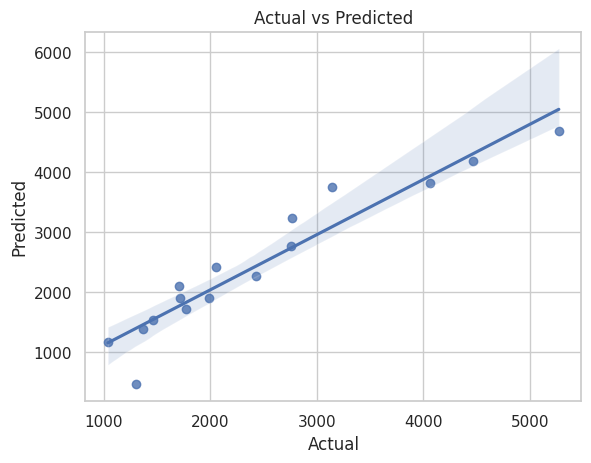

In [ ]:
# Create the DataFrame
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Check the number of rows and sample appropriately
df_sampled = df_results.sample(min(100, len(df_results)))

# Plotting the results
sns.regplot(x='Actual', y='Predicted', data=df_sampled)
plt.title('Actual vs Predicted')
plt.show()

In [ ]:
with open('linear_regression_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

Prediction

In [ ]:
X_pred = pd.DataFrame([
  ["overweight","female","pescatarian","daily","coal","walk/bicycle", np.nan,"often",230,"frequently",210,"large", 4,7,26,1,"No",False,1,0,0,True,0,0,1],
  ["obese","female","vegetarian","less frequently","natural gas","walk/bicycle", np.nan,"often",114,"rarely",9,"extra large",3,9,38,5,"No",False,1,0,0,False,1,0,1]
], columns=[ 'Body_Type', 'Gender', 'Diet', 'How_Often_Shower', 'Heating_Energy_Source',  'Transport', 'Vehicle_Type','Social_Activity','Monthly_Grocery_Bill',  'Frequency_of_Traveling_by_Air', 'Vehicle_Monthly_Distance_Km','Waste_Bag_Size','Waste_Bag_Weekly_Count', 'How_Long_TV_PC_Daily_Hour', 'How_Many_New_Clothes_Monthly', 'How_Long_Internet_Daily_Hour', 'Energy_efficiency','Glass', 'Metal', 'Plastic', 'Paper', 'Oven', 'Microwave', 'Grill', 'Stove'])

y_pred = model.predict(preprocessor.transform(X_pred)).round(0)
print("predicted CarbonEmission: ", y_pred)

X_pred

predicted CarbonEmission:  [2275. 1838.]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,Body_Type,Gender,Diet,How_Often_Shower,Heating_Energy_Source,Transport,Vehicle_Type,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Glass,Metal,Plastic,Paper,Oven,Microwave,Grill,Stove
0,overweight,female,pescatarian,daily,coal,walk/bicycle,NaN,often,230,frequently,210,large,4,7,26,1,No,False,1,0,0,True,0,0,1
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,False,1,0,0,False,1,0,1


In [ ]:
X_pred= df.loc[0:1, X.columns]
y_pred = model.predict(preprocessor.transform(X_pred)).round(0)
print("predicted CarbonEmission of first 2 persons: ", y_pred)

y_true = list(df.loc[0:1, 'CarbonEmission'])
print("actual CarbonEmission of first 2 persons: ", y_true)

X_pred

predicted CarbonEmission of first 2 persons:  [2164. 1838.]
actual CarbonEmission of first 2 persons:  [2238, 1892]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


,Body_Type,Gender,Diet,How_Often_Shower,Heating_Energy_Source,Transport,Vehicle_Type,Social_Activity,Monthly_Grocery_Bill,Frequency_of_Traveling_by_Air,Vehicle_Monthly_Distance_Km,Waste_Bag_Size,Waste_Bag_Weekly_Count,How_Long_TV_PC_Daily_Hour,How_Many_New_Clothes_Monthly,How_Long_Internet_Daily_Hour,Energy_efficiency,Glass,Metal,Paper,Plastic,Grill,Microwave,Oven,Stove
0,overweight,female,pescatarian,daily,coal,public,NaN,often,230,frequently,210,large,4,7,26,1,No,0,1,0,0,0,0,1,1
1,obese,female,vegetarian,less frequently,natural gas,walk/bicycle,NaN,often,114,rarely,9,extra large,3,9,38,5,No,0,1,0,0,0,1,0,1
